<a href="https://colab.research.google.com/github/jkm243/TSOS/blob/master/Archicad_Fluzzy_Kand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Charger les données JSON
json_data = """
{
    "inference_id": "c845e173-196b-406c-9234-496ee6ac735e",
    "time": 0.3180401959998562,
    "image": {
        "width": 736,
        "height": 552
    },
    "predictions": [
        {
            "x": 379,
            "y": 432.5,
            "width": 114,
            "height": 61,
            "confidence": 0.9654207825660706,
            "class": "shelf",
            "class_id": 11,
            "detection_id": "932f20a7-5b05-4d06-b47f-dbb82e476dff"
        },
        {
            "x": 589.5,
            "y": 157,
            "width": 165,
            "height": 186,
            "confidence": 0.8402619361877441,
            "class": "bedroom",
            "class_id": 7,
            "detection_id": "13892950-631c-4cc8-afb7-ec4d7b176b6e"
        },
        {
            "x": 186,
            "y": 289,
            "width": 60,
            "height": 42,
            "confidence": 0.5250271558761597,
            "class": "stairs",
            "class_id": 12,
            "detection_id": "9f377e20-71ab-4432-9373-5ceb310ac84d"
        },
        {
            "x": 185,
            "y": 288.5,
            "width": 60,
            "height": 39,
            "confidence": 0.5021653771400452,
            "class": "shelf",
            "class_id": 11,
            "detection_id": "b1f47d52-e8a7-41f4-9dbe-327114329b22"
        },
        {
            "x": 139.5,
            "y": 215,
            "width": 149,
            "height": 184,
            "confidence": 0.4978591501712799,
            "class": "bedroom",
            "class_id": 7,
            "detection_id": "a2b543fd-70cc-485e-b109-f914f6db4150"
        },
        {
            "x": 601.5,
            "y": 353,
            "width": 123,
            "height": 184,
            "confidence": 0.43341514468193054,
            "class": "bedroom",
            "class_id": 7,
            "detection_id": "90ba36f1-cbed-4b96-8449-f00a72b4aa9d"
        },
        {
            "x": 576.5,
            "y": 154,
            "width": 193,
            "height": 190,
            "confidence": 0.3017217814922333,
            "class": "room",
            "class_id": 10,
            "detection_id": "48ec49a2-ea2d-4dbb-a593-41dffa417021"
        },
        {
            "x": 274,
            "y": 163.5,
            "width": 178,
            "height": 187,
            "confidence": 0.2849943935871124,
            "class": "bedroom",
            "class_id": 7,
            "detection_id": "e7f4fe93-866d-432e-833e-639fb2cb44e9"
        },
        {
            "x": 455.5,
            "y": 395,
            "width": 153,
            "height": 146,
            "confidence": 0.2765514552593231,
            "class": "bedroom",
            "class_id": 7,
            "detection_id": "e3c588cd-c433-4adf-a673-575a5dda4598"
        },
        {
            "x": 109,
            "y": 141.5,
            "width": 88,
            "height": 193,
            "confidence": 0.2713339626789093,
            "class": "way",
            "class_id": 16,
            "detection_id": "a38091a1-374d-4f41-b9f2-1a50d30b9248"
        },
        {
            "x": 161.5,
            "y": 122.5,
            "width": 89,
            "height": 41,
            "confidence": 0.22358547151088715,
            "class": "bedroom",
            "class_id": 7,
            "detection_id": "337a6170-d227-48dd-a5e6-5795bb8481b6"
        },
        {
            "x": 136,
            "y": 181,
            "width": 140,
            "height": 264,
            "confidence": 0.21286432445049286,
            "class": "room",
            "class_id": 10,
            "detection_id": "b618b7cc-3719-49ae-8ef7-564184cb812e"
        },
        {
            "x": 141.5,
            "y": 370.5,
            "width": 149,
            "height": 53,
            "confidence": 0.1878644824028015,
            "class": "way",
            "class_id": 16,
            "detection_id": "ce87d902-6fb8-4607-977d-9b6adb792402"
        },
        {
            "x": 139,
            "y": 408,
            "width": 136,
            "height": 116,
            "confidence": 0.18317954242229462,
            "class": "room",
            "class_id": 10,
            "detection_id": "cf973ce2-e22c-491a-ab58-6464d27633cb"
        },
        {
            "x": 405,
            "y": 186,
            "width": 130,
            "height": 126,
            "confidence": 0.16397003829479218,
            "class": "way",
            "class_id": 16,
            "detection_id": "b513a443-cf86-4510-a86d-e382ad84fed3"
        }
    ]
}
"""

In [3]:
# Convertir en dictionnaire Python
data = json.loads(json_data)

In [4]:
def process_architectural_data(data):
    # Conversion initiale en DataFrame
    df = pd.DataFrame(data['predictions'])

    # Ajouter les coordonnées de fin
    df['x2'] = df['x'] + df['width']
    df['y2'] = df['y'] + df['height']

    # 1. Calcul des métriques de base
    df['surface_px'] = df['width'] * df['height']
    df['surface_m²'] = df['surface_px'] * 0.01  # Hypothèse: 1px = 0.1m
    df['aspect_ratio'] = df['width'] / df['height']

    # 2. Proximité aux circulations (way)
    ways = df[df['class'] == 'way']
    def calculate_way_proximity(row):
        if ways.empty:
            return np.nan
        distances = np.sqrt((ways['x'] - row['x'])**2 + (ways['y'] - row['y'])**2)
        return distances.min()

    df['proximity_way'] = df.apply(calculate_way_proximity, axis=1)

    # 3. Calcul des adjacences
    def check_adjacency(row1, row2):
        return not (row1['x2'] < row2['x'] or
                    row2['x2'] < row1['x'] or
                    row1['y2'] < row2['y'] or
                    row2['y2'] < row1['y'])

    adjacences = []
    for _, row in df.iterrows():
        adjacent = []
        for _, other in df.iterrows():
            if row['detection_id'] != other['detection_id'] and check_adjacency(row, other):
                adjacent.append(other['class'])
        adjacences.append(', '.join(adjacent))
    df['adjacent'] = adjacences

    # 4. Calcul du score flou
    class_weights = {
        'bedroom': 0.9,
        'room': 0.7,
        'way': 0.4,
        'shelf': 0.3,
        'stairs': 0.3
    }

    scaler = MinMaxScaler()
    df['proximity_norm'] = 1 - scaler.fit_transform(df[['proximity_way']])
    df['surface_norm'] = scaler.fit_transform(df[['surface_m²']])

    df['fuzzy_score'] = (
        0.4 * df['class'].map(class_weights) +
        0.3 * df['confidence'] +
        0.2 * df['proximity_norm'] +
        0.1 * df['surface_norm']
    )

    # 5. Génération des recommandations
    def generate_recommendations(row):
        rec = []

        if row['class'] == 'bedroom':
            if 'bathroom' not in row['adjacent']:
                rec.append("Add adjacent bathroom")
            if row['surface_m²'] < 15:
                rec.append("Consider enlarging room")

        elif row['class'] == 'stairs':
            if row['aspect_ratio'] > 1.5:
                rec.append("Check step dimensions for safety")

        elif row['class'] == 'shelf':
            if row['surface_m²'] > 2 and 'way' in row['adjacent']:
                rec.append("Relocate to avoid circulation obstruction")

        return ' | '.join(rec) if rec else 'OK'

    df['recommendations'] = df.apply(generate_recommendations, axis=1)

    return df

,detection_id,class,surface_m²,aspect_ratio,proximity_way,adjacent,fuzzy_score,recommendations
1,13892950-631c-4cc8-afb7-ec4d7b176b6e,bedroom,306.90,0.887097,186.765227,room,0.749120,Add adjacent bathroom
4,a2b543fd-70cc-485e-b109-f914f6db4150,bedroom,274.16,0.809783,79.577007,"stairs, shelf, bedroom, way, room, way",0.720073,Add adjacent bathroom
7,e7f4fe93-866d-432e-833e-639fb2cb44e9,bedroom,332.86,0.951872,132.918208,"bedroom, room, way",0.631800,Add adjacent bathroom
11,b618b7cc-3719-49ae-8ef7-564184cb812e,room,369.60,0.530303,47.846107,"stairs, shelf, bedroom, bedroom, way, way, room",0.606752,OK
10,337a6170-d227-48dd-a5e6-5795bb8481b6,bedroom,36.49,2.170732,55.832338,way,0.587555,Add adjacent bathroom
5,90ba36f1-cbed-4b96-8449-f00a72b4aa9d,bedroom,226.32,0.668478,257.878363,bedroom,0.548638,Add adjacent bathroom
13,cf973ce2-e22c-491a-ab58-6464d27633cb,room,157.76,1.172414,37.583241,"room, way",0.544616,OK
6,48ec49a2-ea2d-4dbb-a593-41dffa417021,room,366.70,1.015789,174.459881,bedroom,0.534375,OK
8,e3c588cd-c433-4adf-a673-575a5dda4598,bedroom,223.38,1.047945,215.014534,"shelf, bedroom",0.533973,Add adjacent bathroom
9,a38091a1-374d-4f41-b9f2-1a50d30b9248,way,169.84,0.455959,0.000000,"stairs, shelf, bedroom, bedroom, room",0.483699,OK


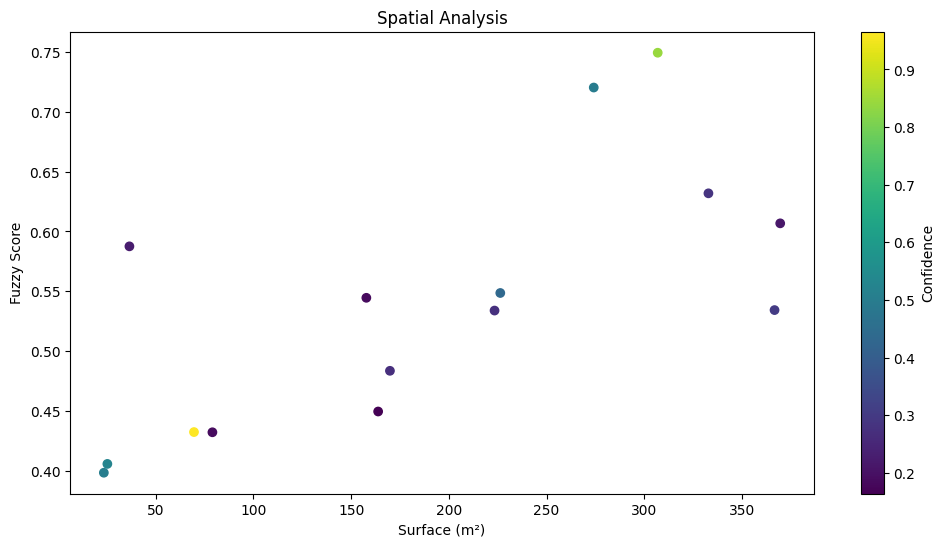


Key Statistics:
• Average bedroom size: 233.4 m²
• Way proximity range: 0.0px - 257.9px
• Recommendation rate: 46.7%


In [5]:
# Traitement des données
processed_df = process_architectural_data(data)

# Affichage des résultats
cols = ['detection_id', 'class', 'surface_m²', 'aspect_ratio',
        'proximity_way', 'adjacent', 'fuzzy_score', 'recommendations']
display(processed_df[cols].sort_values('fuzzy_score', ascending=False))

# Visualisation
plt.figure(figsize=(12, 6))
plt.scatter(processed_df['surface_m²'], processed_df['fuzzy_score'],
            c=processed_df['confidence'], cmap='viridis')
plt.colorbar(label='Confidence')
plt.xlabel('Surface (m²)')
plt.ylabel('Fuzzy Score')
plt.title('Spatial Analysis')
plt.show()

# Génération du rapport
print("\nKey Statistics:")
print(f"• Average bedroom size: {processed_df[processed_df['class'] == 'bedroom']['surface_m²'].mean():.1f} m²")
print(f"• Way proximity range: {processed_df['proximity_way'].min():.1f}px - {processed_df['proximity_way'].max():.1f}px")
print(f"• Recommendation rate: {(processed_df['recommendations'] != 'OK').mean()*100:.1f}%")

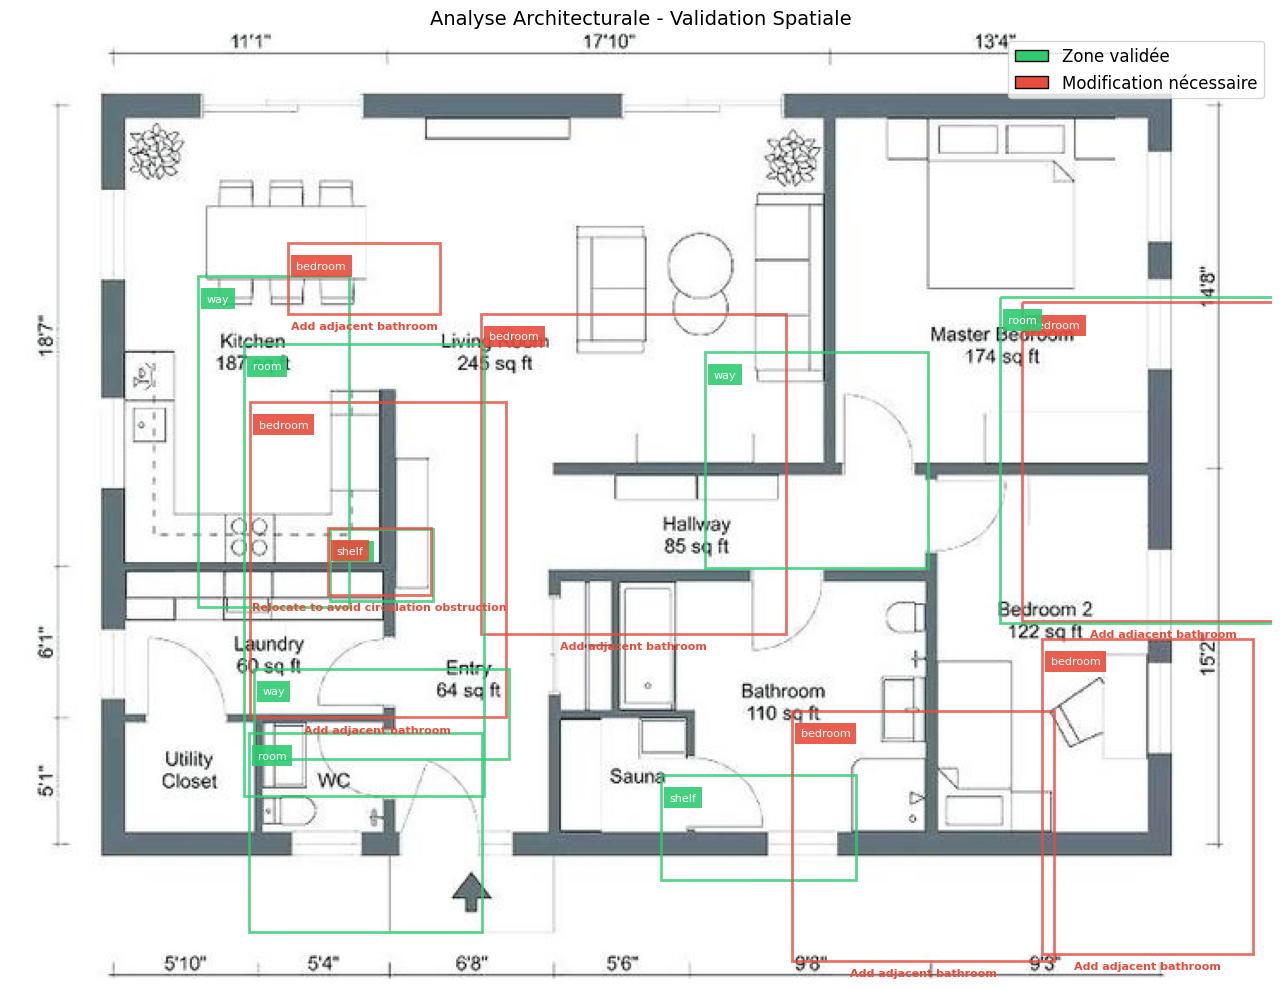

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from PIL import Image
import requests
from io import BytesIO

# Télécharger l'image
image_url = "https://i.pinimg.com/736x/80/c1/d9/80c1d9a5c9361c9e88b5a71351ca1f9e.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Redimensionner selon les dimensions du JSON
target_size = (data['image']['width'], data['image']['height'])
img = img.resize(target_size)

# Créer la figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(img)

# Palette de couleurs
colors = {
    'OK': '#2ecc71',      # Vert
    'Modification': '#e74c3c' # Rouge
}

# Légende personnalisée
legend_elements = [
    patches.Patch(facecolor=colors['OK'], edgecolor='black', label='Zone validée'),
    patches.Patch(facecolor=colors['Modification'], edgecolor='black', label='Modification nécessaire')
]

# Dessiner les rectangles et annotations
for _, row in processed_df.iterrows():
    color = colors['OK'] if row['recommendations'] == 'OK' else colors['Modification']

    # Rectangle principal
    rect = patches.Rectangle(
        (row['x'], row['y']),
        row['width'],
        row['height'],
        linewidth=2,
        edgecolor=color,
        facecolor='none',
        alpha=0.8
    )
    ax.add_patch(rect)

    # Annotation de classe
    plt.text(
        row['x'] + 5,
        row['y'] + 15,
        row['class'],
        color='white',
        fontsize=8,
        bbox=dict(facecolor=color, alpha=0.9, edgecolor='none')
    )

    # Annotation de recommandation si nécessaire
    if row['recommendations'] != 'OK':
        plt.text(
            row['x'] + row['width']/2,
            row['y'] + row['height'] + 10,
            row['recommendations'],
            color=colors['Modification'],
            fontsize=8,
            ha='center',
            va='bottom',
            weight='bold'
        )

# Ajouter la légende
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Paramètres d'affichage
plt.title("Analyse Architecturale - Validation Spatiale", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Sauvegarder le résultat
fig.savefig('architectural_analysis.jpg', dpi=300, bbox_inches='tight')
